## 改良したWMTSによるコンディションスコアの算出
- 相関係数の推移を算出

In [1]:
import time

import pandas as pd
import numpy as np
import random
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# 自作関数
from dataload.data_load import data_load
from func.my_func import *

In [2]:
keio_df = pd.read_csv('../../../野球部データ収集/keio_data/keio.csv', parse_dates=[1])
use_feature_df = keio_df[['UserID', 'TargetDate', 'Score', 'DiffRestHrValue', 'DiffWakedHrValue',
        'StressCount', 'DeepSleepRate', 'LowActivityHourws']]

answer_df = pd.read_csv('../../../野球部データ収集/keio_data/keio_answer_data.csv', parse_dates=[1])
category = pd.read_csv('../../../野球部データ収集/keio_data/category.csv', encoding='shift-jis')
answer_df = answer_df.merge(category)

def create_user_feature(user_id):
    output_df = use_feature_df[use_feature_df['UserID'] == user_id].reset_index(drop=True)
    output_df['TargetDate'] = output_df['TargetDate'].dt.date
    return output_df

def create_y(user_id):
    _piv_df = answer_df[answer_df['UserID'] == user_id].pivot_table(
        values='value',
        index='TargetDate',
        columns='category'
    ).reset_index()
    _piv_df['TargetDate'] = _piv_df['TargetDate'].dt.date
    _piv_df = _piv_df.drop(['体温', '朝食'], axis=1)
    _piv_df['mean'] = _piv_df.mean(axis=1)
    _piv_df['y'] = _piv_df['mean'].apply(lambda x: 1 if x >= _piv_df['mean'].mean()+_piv_df['mean'].std() else 0)
    for i in ['下肢の状態',	'肘の状態', '肩の状態']:
        _piv_df[f'y_{i}'] = _piv_df[i].apply(lambda x: int(x > 3))
    return _piv_df


In [3]:
# users = keio_df['UserID'].unique()
users = [
    # 1504, 
    1505, 
    1755, 
    1781, 
    1774, 
    1773
]
# user_id = users[0]

1505


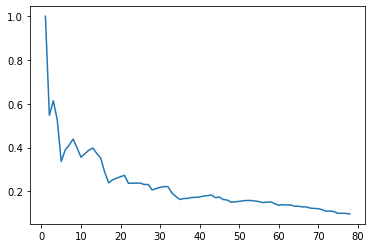

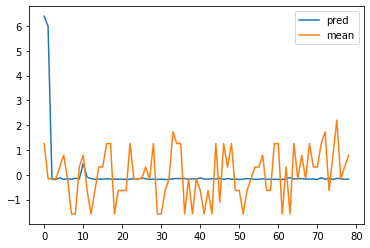

1755


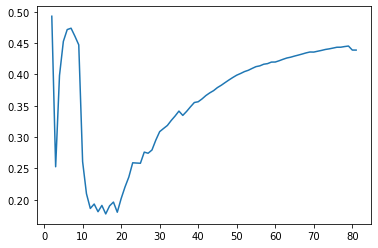

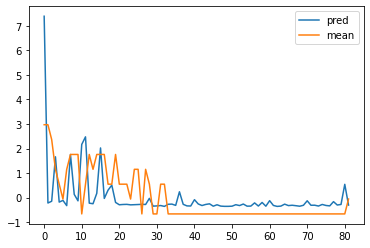

1781


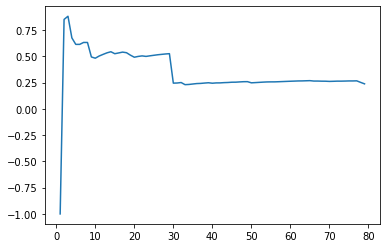

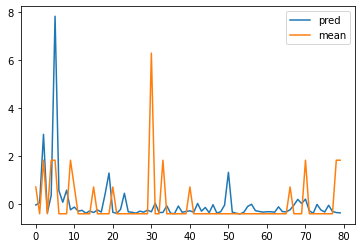

1774


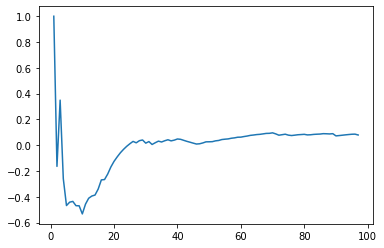

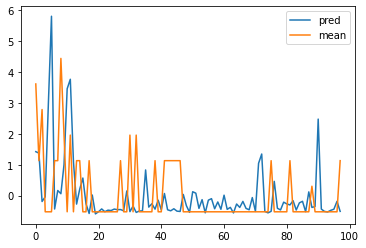

1773


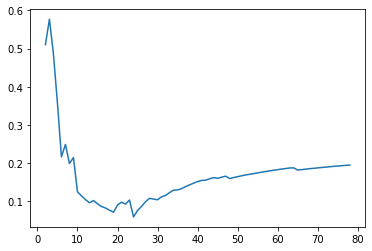

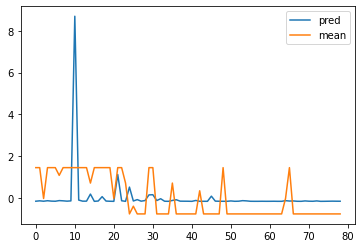

In [8]:
from sklearn.preprocessing import StandardScaler


score_df = pd.DataFrame(index=users, columns=['mean'])
weight_df_dict = {}
time_series_corr_df_dict = {}

for user_id in users:
    # 重みを初期化
    weight_df = pd.DataFrame(columns=['DiffRestHrValue', 'DiffWakedHrValue', 'StressCount',
                'DeepSleepRate', 'LowActivityHourws'])
    
    # user_idに対応したデータを取得
    print(user_id)
    _X = create_user_feature(user_id).drop(['UserID', 'Score'], axis=1)
    _y = create_y(user_id)
    df = pd.merge(_X, _y, how='inner', on='TargetDate')
    _X = df[['DiffRestHrValue', 'DiffWakedHrValue', 'StressCount',
                'DeepSleepRate', 'LowActivityHourws']]
    _X = _X.fillna(_X.mean())
    # 相関係数の推移を保存するdataframeを初期化
    time_series_corr_df = pd.DataFrame(columns=['corr'], index=range(len(df)-7))

    # 逐次予測を実行
    for n in range(7, len(df)):
        X = _X.iloc[:n]
        y = _y['y'].iloc[:n]
        X_test = _X.iloc[[n]]
        # 正常データのみを使用して標準化
        scaler = StandardScaler()
        if len(X[y == 0]) > 3:
            scaler.fit(X[y == 0])
            normal_Z = scaler.transform(X[y == 0])
            if len(X[y == 1]) > 0:
                anomaly_Z = scaler.transform(X[y == 1])    # 正常データのみを使用して共分散行列を計算
            inv_C = inv_cov(normal_Z)
            # 異常データと直交表を用いてSN比を計算
            #L8直行表
            l8 = np.array([
                [1,1,1,1,1,1,1],
                [1,1,1,2,2,2,2],
                [1,2,2,1,1,2,2],
                [1,2,2,2,2,1,1],
                [2,1,2,1,2,1,2],
                [2,1,2,2,1,2,1],
                [2,2,1,1,2,2,1],
                [2,2,1,2,1,1,2]
                ])
            l8 = (l8 == 1)
            l8 = l8[:, :len(X.columns)]

            if len(X[y == 1]) > 0:
                #異常データのマハラノビス距離
                result = np.zeros((l8.shape[0], anomaly_Z.shape[0]))
                for i, l8_row in enumerate(l8):
                    result[i] = cal_MD(anomaly_Z[:, l8_row], inv_C[l8_row][:,l8_row])

                #SN比
                sn = np.zeros(l8.shape[0])
                for idx, row in enumerate(result):
                    sum_MD = 0
                    for i in range(len(row)):
                        sum_MD += 1 / row[i]
                    sn[idx] = -10 * math.log10(sum_MD / len(row))
                    
                # SN比を利用し，不要と思われる変数を削除する
                # 変数選択
                df_gain = pd.DataFrame(index=X.columns, columns=['効果ゲイン','残す'])
                for i, clm in enumerate(X.columns):
                    gain = sum(sn[l8.T[i]]) - sum(sn[~l8.T[i]])
                    df_gain.loc[df_gain.index == clm, '効果ゲイン'] = gain
                    df_gain.loc[df_gain.index == clm, '残す'] = gain > 0
                # 選択された変数を保存
                select_columns = X.columns
                
                select_gain = df_gain['効果ゲイン'].values
                
                select_columns_weight = (select_gain - select_gain.min()) / (select_gain.max() - select_gain.min())
                # 選択変数でのスケーラーと共分散行列を計算
                result_scaler = StandardScaler()
                result_scaler.fit(X[select_columns][y == 0])
                result_Z = result_scaler.transform(X[select_columns][y == 0])
                result_inv_C = inv_cov(result_Z)
                
                proba, _ = predict_WMTS(X_test, result_scaler, result_inv_C, select_columns, select_columns_weight, threshold=0)
                df.loc[n, 'pred'] = list(proba)[0]
                weight_df = weight_df.append(pd.Series(data=select_columns_weight, index=select_columns), ignore_index=True)
                
            else:
                result_scaler = scaler
                result_inv_C = inv_C
                select_columns = X.columns
                df.loc[n, 'pred'] = list(predict_MD(X_test, result_scaler, result_inv_C, select_columns))[0]
        else:
            scaler.fit(X)
            Z = scaler.transform(X)
            inv_C = inv_cov(Z)
            _Z = scaler.transform(X_test)
            md = np.dot(_Z, inv_C)
            MD = np.dot(md, _Z.T) / _Z.shape[1]
            df.loc[n, 'pred'] = MD[0][0]

        # その時点での相関係数を保存
        time_series_corr_df.iloc[n-7] = df[['pred', 'mean']].iloc[7:].corr().iloc[0][1]
    
    plt.plot(time_series_corr_df)
    plt.show()
    scaler = StandardScaler()
    plt.plot(scaler.fit_transform(df[['pred', 'mean']].iloc[7:]))
    plt.legend(['pred', 'mean'])
    plt.show()
    score_df.loc[user_id] = df[['pred', 'mean']].iloc[7:].corr().iloc[0][1]
    weight_df_dict[user_id] = weight_df
    time_series_corr_df_dict[user_id] = time_series_corr_df

In [11]:
import numpy as np
np.save('+WMTS_time_series_corr_df_dict.npy', time_series_corr_df_dict)


### 考察
- 30日以降くらいから相関係数が安定し始める
- 最初の10日間くらいは安定していないがその後順調に相関係数が上がっていくサンプルも見られる（1773，1774，1755）
- 反対に時間が経つにつれて相関係数が落ちていくサンプルもある．（1505）

In [45]:
score_df

,mean
1505,0.096566
1755,0.438803
1781,0.238078
1774,0.079127
1773,0.19499


In [46]:
score_df.mean()

mean    0.209513
dtype: float64

## 変数重要度

,DiffRestHrValue,DiffWakedHrValue,StressCount,DeepSleepRate,LowActivityHourws
1505,0.36735,0.585126,0.229777,0.165913,0.85592
1755,0.291074,0.471098,0.565352,0.292478,0.855155
1781,0.804014,0.412357,0.135602,0.86933,0.428409
1774,0.132222,0.889624,0.473386,0.811504,0.608988
1773,0.000427,0.9683,0.858968,0.887446,0.824072
mean,0.319017,0.665301,0.452617,0.605334,0.714509


<AxesSubplot:>

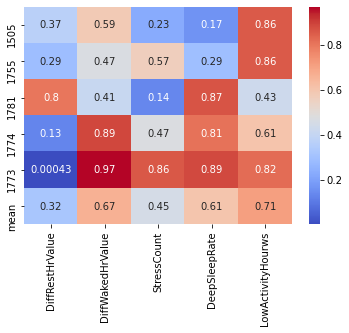

In [47]:
all_user_mean_weight_df = pd.DataFrame(index=users, columns=['DiffRestHrValue', 'DiffWakedHrValue', 'StressCount', 'DeepSleepRate', 'LowActivityHourws'])
for user_id in users:
    all_user_mean_weight_df.loc[user_id] = weight_df_dict[user_id].mean()
all_user_mean_weight_df.loc['mean'] = all_user_mean_weight_df.mean()
display(all_user_mean_weight_df)
sns.heatmap(all_user_mean_weight_df.astype(float), annot=True, cmap='coolwarm')

### 個人間で重要な特徴が異なる
- 個人間の違いは考慮できている．その人特有のモデルでノビスコアよりも精度がいい．
- LowActivityHourwsは全体的に高い値，バンドをつけている時といない時に関係があるか？

In [31]:
all_user_mean_weight_df.mean()

DiffRestHrValue      0.319017
DiffWakedHrValue     0.665301
StressCount          0.452617
DeepSleepRate        0.605334
LowActivityHourws    0.714509
dtype: float64

In [32]:
all_user_mean_weight_df.agg(['mean', 'std']).T

,mean,std
DiffRestHrValue,0.319017,0.273763
DiffWakedHrValue,0.665301,0.223720
StressCount,0.452617,0.256288
DeepSleepRate,0.605334,0.310727
LowActivityHourws,0.714509,0.170159


In [33]:
whole_weight_df.mean()

DiffRestHrValue      0.326483
DiffWakedHrValue     0.661978
StressCount          0.436043
DeepSleepRate        0.604442
LowActivityHourws    0.704987
dtype: float64

## 最後の10日の変数重要度

1505


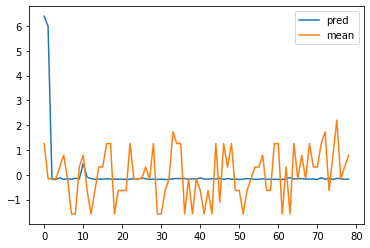

1755


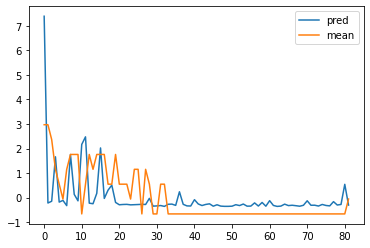

1781


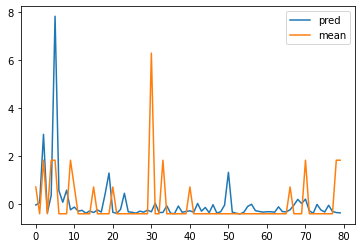

1774


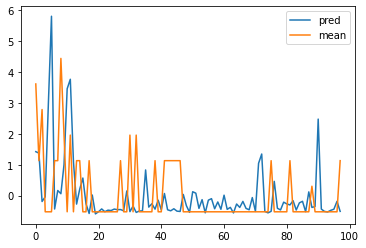

1773


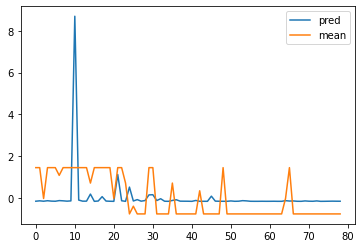

In [41]:
from sklearn.preprocessing import StandardScaler


score_df = pd.DataFrame(index=users, columns=['mean'])
weight_df_dict = {}

for user_id in users:
    weight_df = pd.DataFrame(columns=['DiffRestHrValue', 'DiffWakedHrValue', 'StressCount',
                'DeepSleepRate', 'LowActivityHourws'])
    print(user_id)
    _X = create_user_feature(user_id).drop(['UserID', 'Score'], axis=1)
    _y = create_y(user_id)
    df = pd.merge(_X, _y, how='inner', on='TargetDate')
    _X = df[['DiffRestHrValue', 'DiffWakedHrValue', 'StressCount',
                'DeepSleepRate', 'LowActivityHourws']]
    _X = _X.fillna(_X.mean())
    for n in range(7, len(df)):
        X = _X.iloc[:n]
        y = _y['y'].iloc[:n]
        X_test = _X.iloc[[n]]
        # 正常データのみを使用して標準化
        scaler = StandardScaler()
        if len(X[y == 0]) > 3:
            scaler.fit(X[y == 0])
            normal_Z = scaler.transform(X[y == 0])
            if len(X[y == 1]) > 0:
                anomaly_Z = scaler.transform(X[y == 1])    # 正常データのみを使用して共分散行列を計算
            inv_C = inv_cov(normal_Z)
            # 異常データと直交表を用いてSN比を計算
            #L8直行表
            l8 = np.array([
                [1,1,1,1,1,1,1],
                [1,1,1,2,2,2,2],
                [1,2,2,1,1,2,2],
                [1,2,2,2,2,1,1],
                [2,1,2,1,2,1,2],
                [2,1,2,2,1,2,1],
                [2,2,1,1,2,2,1],
                [2,2,1,2,1,1,2]
                ])
            l8 = (l8 == 1)
            l8 = l8[:, :len(X.columns)]

            if len(X[y == 1]) > 0:
                #異常データのマハラノビス距離
                result = np.zeros((l8.shape[0], anomaly_Z.shape[0]))
                for i, l8_row in enumerate(l8):
                    result[i] = cal_MD(anomaly_Z[:, l8_row], inv_C[l8_row][:,l8_row])

                #SN比
                sn = np.zeros(l8.shape[0])
                for idx, row in enumerate(result):
                    sum_MD = 0
                    for i in range(len(row)):
                        sum_MD += 1 / row[i]
                    sn[idx] = -10 * math.log10(sum_MD / len(row))
                    
                # SN比を利用し，不要と思われる変数を削除する
                # 変数選択
                df_gain = pd.DataFrame(index=X.columns, columns=['効果ゲイン','残す'])
                for i, clm in enumerate(X.columns):
                    gain = sum(sn[l8.T[i]]) - sum(sn[~l8.T[i]])
                    df_gain.loc[df_gain.index == clm, '効果ゲイン'] = gain
                    df_gain.loc[df_gain.index == clm, '残す'] = gain > 0
                # 選択された変数を保存
                select_columns = X.columns
                
                select_gain = df_gain['効果ゲイン'].values
                
                select_columns_weight = (select_gain - select_gain.min()) / (select_gain.max() - select_gain.min())
                # 選択変数でのスケーラーと共分散行列を計算
                result_scaler = StandardScaler()
                result_scaler.fit(X[select_columns][y == 0])
                result_Z = result_scaler.transform(X[select_columns][y == 0])
                result_inv_C = inv_cov(result_Z)
                
                proba, _ = predict_WMTS(X_test, result_scaler, result_inv_C, select_columns, select_columns_weight, threshold=0)
                df.loc[n, 'pred'] = list(proba)[0]
                if n > len(df)-10:
                    weight_df = weight_df.append(pd.Series(data=select_columns_weight, index=select_columns), ignore_index=True)
                
            else:
                result_scaler = scaler
                result_inv_C = inv_C
                select_columns = X.columns
                df.loc[n, 'pred'] = list(predict_MD(X_test, result_scaler, result_inv_C, select_columns))[0]
        else:
            scaler.fit(X)
            Z = scaler.transform(X)
            inv_C = inv_cov(Z)
            _Z = scaler.transform(X_test)
            md = np.dot(_Z, inv_C)
            MD = np.dot(md, _Z.T) / _Z.shape[1]
            df.loc[n, 'pred'] = MD[0][0]
    scaler = StandardScaler()
    plt.plot(scaler.fit_transform(df[['pred', 'mean']].iloc[7:]))
    plt.legend(['pred', 'mean'])
    plt.show()
    score_df.loc[user_id] = df[['pred', 'mean']].iloc[7:].corr().iloc[0][1]
    weight_df_dict[user_id] = weight_df

In [42]:
score_df.mean()

mean    0.209513
dtype: float64

,DiffRestHrValue,DiffWakedHrValue,StressCount,DeepSleepRate,LowActivityHourws
1505,0.410714,0.605659,0.22645,0.14553,1.0
1755,0.360517,0.003975,0.896223,0.196324,0.976465
1781,0.888889,0.480916,0.074436,0.887368,0.560958
1774,0.135791,0.358904,0.514472,0.490085,1.0
1773,0.0,1.0,0.938324,0.979807,0.932489
mean,0.359182,0.489891,0.529981,0.539823,0.893982


<AxesSubplot:>

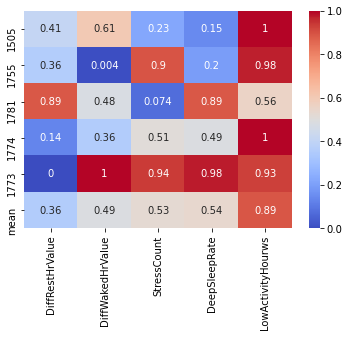

In [43]:
all_user_mean_weight_df = pd.DataFrame(index=users, columns=['DiffRestHrValue', 'DiffWakedHrValue', 'StressCount', 'DeepSleepRate', 'LowActivityHourws'])
for user_id in users:
    all_user_mean_weight_df.loc[user_id] = weight_df_dict[user_id].mean()
all_user_mean_weight_df.loc['mean'] = all_user_mean_weight_df.mean()
display(all_user_mean_weight_df)
sns.heatmap(all_user_mean_weight_df.astype(float), annot=True, cmap='coolwarm')

In [37]:
all_user_mean_weight_df.mean()

DiffRestHrValue      0.359182
DiffWakedHrValue     0.489891
StressCount          0.529981
DeepSleepRate        0.539823
LowActivityHourws    0.893982
dtype: float64

In [38]:
all_user_mean_weight_df.agg(['mean', 'std']).T

,mean,std
DiffRestHrValue,0.359182,0.304027
DiffWakedHrValue,0.489891,0.324643
StressCount,0.529981,0.346632
DeepSleepRate,0.539823,0.343601
LowActivityHourws,0.893982,0.168328
